In [2]:
# Note that this ipynb is based on the blogpost made by Yarin Gal which can be found at
# link: http://www.cs.ox.ac.uk/people/yarin.gal/website/blog_3d801aa532c1ce.html
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

import sys
import pickle
import time

from dataset import Dataset

In [3]:

class CNN_Text(nn.Module):
    
    def __init__(self, embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout):
        super(CNN_Text, self).__init__()
        
        V = embed_num
        D = embed_dim
        C = class_num
        Ci = 1
        Co = kernel_num
        Ks = kernel_sizes

#         self.embed = nn.Embedding(V, D)
        self.convs = nn.ModuleList([nn.Conv2d(Ci, Co, (K, D)) for K in Ks])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(Ks) * Co, C)



    def forward(self, x):
#         x = self.embed(x)  # (N, W, D)
    
        x = x.unsqueeze(1)  # (N, Ci, W, D)

        x = [torch.tanh(conv(x)).squeeze(3) for conv in self.convs]  # [(N, Co, W), ...]*len(Ks)

        x = [self.dropout(i) for i in x]
        
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)

        x = torch.cat(x, 1)

#         x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc1(x)  # (N, C)
        return logit
    


In [39]:
# DIT NIET VERWIJDEREN
# DIT MAAKT EEN PLOTJE WAT NOG OPGEMAAKT MOET WORDEN MAAR WAARVAN HET IDEE LOGISCH IS
# VAR --> GAAT OMHOOG WANT DE WAARDES IN DE SOFTMAX GAAN STEEDS MEER VERSCHILLEN NAARMATE HIJ TRAINT

from scipy.special import softmax
from collections import defaultdict
device = "cuda" if torch.cuda.is_available() else "cpu"
kernel_sizes = [2, 3, 4]
cnn_classifier = CNN_Text(
        embed_dim=768,
        embed_num=512,
        class_num=6,
        kernel_num=len(kernel_sizes),
        kernel_sizes=kernel_sizes,
        dropout=0.5
    ).to(device)

model_epochs = [5,10,25,50,75]
T = 100

l = 1
p_dropout = 0.5
N = 500
weight_decay = 4e-4
tau = ((l**2) * (1-p_dropout)) / (2 * N * weight_decay) 

processed_test_path = "C:/Users/Laurence/Desktop/QuestionClassification-master_vos/code/data/test/test_pre_processed/"
test_dataset = Dataset(processed_test_path)

def calc_var(tau, test_dataset, cnn_classifier, model_folder, model_size):
    all_results_EV = []
    all_results_PV = []
    results_EV = defaultdict(list)
    results_PV = defaultdict(list)
    for m_e in model_epochs:
        print(f"current model: {m_e}")
        if model_size == "big":
            model_path = f"{model_folder}/big_random_seed_7_epoch_{m_e}.p"
        elif model_size == "small":
            model_path = f"{model_folder}/random_seed_2_epoch_{m_e}.p"
        cnn_classifier.load_state_dict(torch.load(model_path))
        predictive_var = []
        for file_index in range(len(test_dataset)):
            batch, labels = test_dataset[file_index]
            for index, (x,y) in enumerate(zip(batch, labels)):
                y_np = y.numpy()
                class_label = np.where(y_np == 1.0)[0][0]
                probs = []

                for _ in range(T):
                    # do forward pass T times
                    #probs += [cnn_classifier.forward(x.unsqueeze(0).float().to(device)).detach().cpu().numpy()[0]]
                    #probs.append(prob)
                    probs += [softmax(cnn_classifier.forward(x.unsqueeze(0).float().to(device)).detach().cpu().numpy()[0])]

                #print(np.mean(probs))
                p_y_var = np.var(probs) + tau**-1
                predictive_var.append(p_y_var)

        results_PV[m_e] = predictive_var
        
    return results_PV





In [ ]:
model_path_big = "C:/Users/Laurence/Desktop/QuestionClassification-master_vos/predictive_variance/cnn_models"
results_PV_big = calc_var(tau, test_dataset, cnn_classifier, model_path_big, model_size = "big")

In [40]:
model_path_small = "C:/Users/Laurence/Desktop/QuestionClassification-master_vos/predictive_variance/cnn_models_small"
results_PV_small = calc_var(tau, test_dataset, cnn_classifier, model_path_small, model_size = "small")

current model: 5
current model: 10
current model: 25
current model: 50
current model: 75


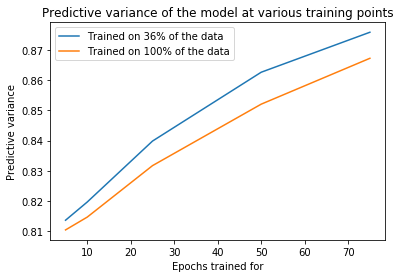

In [42]:
results_small, results_big = [], []
for model, results in results_PV_small.items():
    #print(model, results)
    #print([x for x in range(0,len(model_epochs)+1)])
    #plt.scatter(np.asarray([x for x in range(0,len(model_epochs)+1)]),np.mean(results).T, label = f"epoch{model}", marker = 'o')
    results_small.append(np.mean(results))

for model, results in results_PV_big.items():
    results_big.append(np.mean(results))
#print(results1)
#plt.scatter([x for x in range(0,len(model_epochs))], results1)
plt.xlabel("Epochs trained for")
plt.ylabel("Predictive variance")
plt.title("Predictive variance of the model at various training points")
plt.plot(model_epochs, results_small, label = "Trained on 36% of the data")
plt.plot(model_epochs, results_big, label = "Trained on 100% of the data")
plt.legend()
plt.savefig("predvar5epochs")
plt.show()

In [ ]:
%%%%%%%%%%%%%